In [13]:
import sys

sys.path.insert(0, r"/mnt/c/Users/Trez/Desktop/tudat-bundle/tudatpy/")
from tudatpy.data.mpc import BatchMPC
from tudatpy.data.horizons import HorizonsQuery

from tudatpy.numerical_simulation import environment_setup
from tudatpy.interface import spice

import numpy as np
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import os

from astroquery.mpc import MPC

import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from collections.abc import Iterable

import cartopy
from typing import Union, Tuple
import random
from astropy_healpix import HEALPix
import healpy
from astropy.units import Quantity
from astropy.time import Time

import seaborn as sns
import re
from typing import Union, Tuple

spice.load_standard_kernels()

In [14]:
lowres_folder = "debias_2018"
# highres_folder = "debias_2018"
bias_file = os.path.join(lowres_folder, "bias.dat")

BIAS_LOWRES_FILE = bias_file
BIAS_HIGHRES_FILE = os.path.join("debias_hires2018", "bias.dat")
tiles_file = os.path.join(lowres_folder, "tiles.dat")

In [15]:
tiles = pd.read_csv(
    tiles_file,
    sep=" ",
    skiprows=[0, 1],
    skipinitialspace=True,
    names=["tile_number", "RA", "DEC"],
)

print(tiles)

       tile_number        RA       DEC
0                0  0.785398  1.558038
1                1  2.356194  1.558038
2                2  3.926991  1.558038
3                3  5.497787  1.558038
4                4  0.392699  1.545280
...            ...       ...       ...
49147        49147  5.890486 -1.545280
49148        49148  0.785398 -1.558038
49149        49149  2.356194 -1.558038
49150        49150  3.926991 -1.558038
49151        49151  5.497787 -1.558038

[49152 rows x 3 columns]


In [16]:
print(["a", "b"] * 2)

['a', 'b', 'a', 'b']


In [17]:
catalog_flags = (
    "a",
    "b",
    "c",
    "d",
    "e",
    "g",
    "i",
    "j",
    "l",
    "m",
    "n",
    "o",
    "p",
    "q",
    "r",
    "t",
    "u",
    "v",
    "w",
    "L",
    "N",
    "Q",
    "R",
    "S",
    "U",
    "Y",
)


values = ["RA", "DEC", "PMRA", "PMDEC"]

m_index = pd.MultiIndex.from_product(
    [catalog_flags, values],
    names=["catalog", "value"],
)


bias = pd.read_csv(
    bias_file,
    sep=" ",
    skiprows=23,
    skipinitialspace=True,
    # header=[0, 1],
    # names=["tile_number", "RA", "DEC"],
    index_col=None,
    header=None,
    # names = m_index
    # names = (["RA", "DEC", "PMRA", "PMDEC"] * 26) + ["drop"]
).iloc[:, :-1]

bias.columns = m_index
# m_index = pd.MultiIndex(
#     levels=["catalog", "value"],
#     codes=[0, 1],
#     names=(
#         ["a", "b", "c", "d", "e", "g", "i", "j", "l", "m", "n", "o", "p", "q", "r", "t", "u", "v", "w", "L", "N", "Q", "R", "S", "U", "Y",],
#         ["RA", "DEC", "PMRA", "PMDEC"],
#     ),
# )
# bias.s(m_index)
# print(bias.columns)
print(bias.head(5))


catalog      a                         b                         c         \
value       RA    DEC  PMRA PMDEC     RA    DEC  PMRA PMDEC     RA    DEC   
0        0.279  0.326 -0.49 -1.04  0.287  0.336 -0.50 -1.01 -0.055 -0.075   
1        0.143 -0.224 -1.08  0.61  0.125 -0.224 -1.10  0.52 -0.136  0.084   
2       -0.139 -0.130  0.52  1.11 -0.134 -0.119  0.56  1.16 -0.031  0.189   
3       -0.334  0.213  1.16 -0.45 -0.342  0.206  1.19 -0.45  0.113 -0.017   
4        0.143  0.597  0.19 -1.30  0.153  0.601  0.34 -1.24  0.071 -0.072   

catalog  ...     S            U                         Y                     
value    ...  PMRA PMDEC     RA    DEC  PMRA PMDEC     RA    DEC  PMRA PMDEC  
0        ...  1.21 -0.29  0.009  0.014 -0.54 -0.90 -0.006 -0.005  0.40  0.37  
1        ...  2.32 -1.32  0.014 -0.010 -0.88  0.68 -0.008  0.004  0.54 -0.24  
2        ...  2.39  2.47 -0.010 -0.013  0.62  0.86 -0.004 -0.005  0.24  0.31  
3        ...  5.43  0.34 -0.016  0.009  1.02 -0.61 -0.001 -0.005 

In [18]:
tdeg = tiles.apply(np.degrees)

In [19]:
def plot_biases(mpc_flag, name, vminmax_pos, vminmax_mot):
    proj = cartopy.crs.Mollweide(central_longitude=0, globe=None)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
        2, 2, subplot_kw={"projection": proj}, figsize=(9, 6.5)
    )
    for ax in fig.get_axes():
        ax.set_global()
    ax1.scatter(x = -tdeg.RA, y=tdeg.DEC, marker=".", s=1, c=bias[mpc_flag].RA, cmap=cm.jet, transform=cartopy.crs.Geodetic(), vmin=-vminmax_pos, vmax=vminmax_pos)
    ax2.scatter(x = -tdeg.RA, y=tdeg.DEC, marker=".", s=1, c=bias[mpc_flag].DEC, cmap=cm.jet, transform=cartopy.crs.Geodetic(), vmin=-vminmax_pos, vmax=vminmax_pos)
    ax3.scatter(x = -tdeg.RA, y=tdeg.DEC, marker=".", s=1, c=bias[mpc_flag].PMRA, cmap=cm.jet, transform=cartopy.crs.Geodetic(), vmin=-vminmax_mot, vmax=vminmax_mot)
    ax4.scatter(x = -tdeg.RA, y=tdeg.DEC, marker=".", s=1, c=bias[mpc_flag].PMDEC, cmap=cm.jet, transform=cartopy.crs.Geodetic(), vmin=-vminmax_mot, vmax=vminmax_mot)

    for ax in fig.get_axes():
        # ax.set_extent([0, 180 + 360, -90, 90], crs=proj)
        ax.gridlines(draw_labels=False, dms=True, x_inline=True, y_inline=False)

    for ax in (ax1, ax2):
        label = r"$\Delta_{\alpha_{J_{2000}}}$[arcsec]"
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("bottom", size="5%", pad=0.05, axes_class=plt.Axes)
        plt.colorbar(cm.ScalarMappable(cmap=cm.jet, norm=colors.Normalize(vmin=-vminmax_pos, vmax=vminmax_pos)), cax=cax, orientation="horizontal", label=label)
    for ax in (ax3, ax4):
        label = r"$\Delta_{\delta_{J_{2000}}}$[mas/yr]"
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("bottom", size="5%", pad=0.05, axes_class=plt.Axes)
        plt.colorbar(cm.ScalarMappable(cmap=cm.jet, norm=colors.Normalize(vmin=-vminmax_mot, vmax=vminmax_mot)), cax=cax, orientation="horizontal", label=label)

    ax1.set_title(f"{name}\nPosition Correction (RAcos(DEC))")
    ax2.set_title(f"{name}\nPosition Correction (DEC)")

    ax3.set_title(f"{name}\nProper Motion Correction (RAcos(DEC))")
    ax4.set_title(f"{name}\nProper Motion Correction (DEC)")
    plt.show()

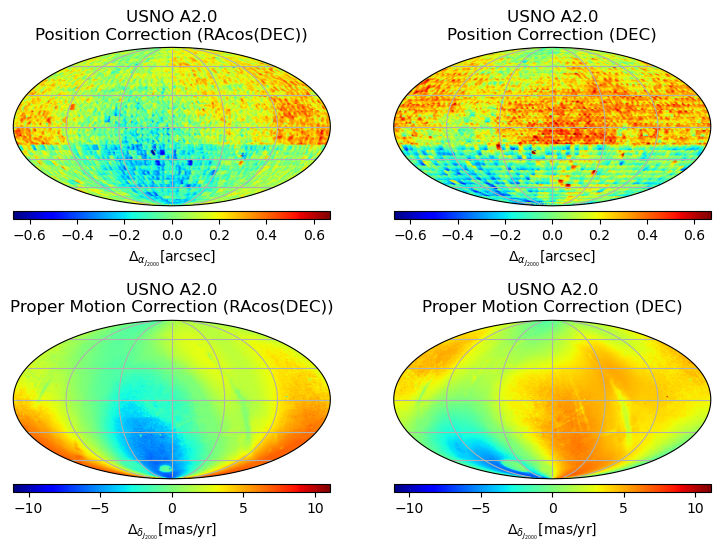

In [20]:
plot_biases("c", "USNO A2.0", vminmax_pos=0.67, vminmax_mot=11.07)
# plot_biases("t", "PPM XL", vminmax_pos=0.11, vminmax_mot=8.03)
# plot_biases("q", "UCAC 4", vminmax_pos=0.07, vminmax_mot=5.03)
# plot_biases("N", "SDSS DR 7", vminmax_pos=0.1, vminmax_mot=0.28)

In [21]:
def load_bias_file(
    filepath: str,
    Nside: Union[None, int] = None,
    catalog_flags: Union[None, list] = None,
):

    # auto retrieve NSIDE
    if Nside is None:
        counter = 0
        with open(filepath, "r") as file:
            while counter < 10:
                line = file.readline()
                pattern = r"! NSIDE=\s*(\d+)"
                match = re.search(pattern, line)
                if match:
                    Nside = match.group(1)
                    break
                counter += 1
        if Nside is None:
            raise ValueError(
                "Could not automatically retrieve NSIDE, please provide it as a parameter"
            )

    if catalog_flags is None:
        catalog_flags = [
            "a",
            "b",
            "c",
            "d",
            "e",
            "g",
            "i",
            "j",
            "l",
            "m",
            "n",
            "o",
            "p",
            "q",
            "r",
            "t",
            "u",
            "v",
            "w",
            "L",
            "N",
            "Q",
            "R",
            "S",
            "U",
            "Y",
        ]
    catalog_flags = catalog_flags + ["unknown"]

    values = ["RA", "DEC", "PMRA", "PMDEC"]

    # create a multi_index, this effectively creates a df with 3 dimensions. [row, catalog, value]
    m_index = pd.MultiIndex.from_product(
        [catalog_flags, values],
        names=["catalog", "value"],
    )

    bias_dataframe = pd.read_csv(
        filepath,
        sep=" ",
        skiprows=23,
        skipinitialspace=True,
        index_col=None,
        header=None,
    ).iloc[:, :-1]

    # we add a set of 'unknown' columns to speed up assignment later
    len_df = bias_dataframe.shape[0]
    unknown_columns = np.zeros(shape=(len_df, 4))
    bias_dataframe[["aa", "bb", "cc", "dd"]] = unknown_columns

    # apply the multi_index
    bias_dataframe.columns = m_index
    # stack it so it goes from a Npix x (Ncat x Nvals) to (Npix x Ncat) x Nvals shape
    bias_dataframe = bias_dataframe.stack(level=0)

    return bias_dataframe, Nside


temp, _ = load_bias_file(bias_file)
print(temp)
print(len(temp))
print(temp.index.levels[1])

value            DEC  PMDEC  PMRA     RA
      catalog                           
0     L        0.002  -0.63 -0.93 -0.029
      N        0.000   0.00  0.00  0.000
      Q        0.000   0.00  0.00  0.000
      R        0.057  -1.85 -0.75 -0.012
      S        0.008  -0.29  1.21 -0.003
...              ...    ...   ...    ...
49151 t        0.026   1.90  0.10 -0.084
      u        0.019   0.49  0.89  0.007
      unknown  0.000   0.00  0.00  0.000
      v        0.057   4.50 -2.32 -0.165
      w        0.000   0.00  0.00  0.000

[1327104 rows x 4 columns]
1327104
Index(['L', 'N', 'Q', 'R', 'S', 'U', 'Y', 'a', 'b', 'c', 'd', 'e', 'g', 'i',
       'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 't', 'u', 'unknown', 'v', 'w'],
      dtype='object', name='catalog')


In [22]:
def get_biases_ECFF18(
    RA: Union[float, np.ndarray, list],
    DEC: Union[float, np.ndarray, list],
    epochJ2000secondsTDB: Union[float, np.ndarray, list],
    catalog: Union[str, np.ndarray, list],
    use_highres=False,
    bias_file=None,
    Nside=None,
    catalog_flags=None
) -> Tuple[np.ndarray, np.ndarray]:

    if bias_file is None:
        if use_highres:
            bias_file = BIAS_HIGHRES_FILE
        else:
            bias_file = BIAS_LOWRES_FILE

    # transform input to numpy arrays
    if not isinstance(RA, np.ndarray):
        RA = np.array([RA]).flatten()
    if not isinstance(DEC, np.ndarray):
        DEC = np.array([DEC]).flatten()
    if not isinstance(epochJ2000secondsTDB, np.ndarray):
        epochJ2000secondsTDB = np.array([epochJ2000secondsTDB]).flatten()
    if not isinstance(catalog, np.ndarray):
        catalog = np.array([catalog]).flatten()

    if not (len(RA) == len(DEC) == len(epochJ2000secondsTDB) == len(catalog)):
        raise ValueError("All inputs must have same size")

    # load bias file
    # index matches the pixels
    # this is effectively a 3d table with axes: (pixel, star catalog), value) using pandas multiindex
    bias_df, nside = load_bias_file(bias_file, Nside, catalog_flags)

    # find nearest tile using HEALPix Algorithm and get indices
    # ideally nside should be retrieved from the load_bias_file function
    hp_obj = HEALPix(nside=nside)

    pixels = hp_obj.lonlat_to_healpix(
        Quantity(RA, unit="rad"), Quantity(DEC, unit="rad")
    )

    # retrieve bias values from bias file using indices
    # result is N x 4 biases for the correct star catalog
    all_catalog_ids = bias_df.index.levels[1].to_list()
    # this changes all ids not present in the bias file to unknown, resulting in zero bias
    catalog = ["unknown" if (cat not in all_catalog_ids) else cat for cat in catalog]

    targets = [(pix, cat) for pix , cat in zip(pixels, catalog)]
    biases = bias_df.loc[targets, ["RA", "DEC", "PMRA", "PMDEC"]].to_numpy()

    # transform the values with formulas given, time to JD TT
    J2000_jd = 2451545.0
    epochs = (epochJ2000secondsTDB / 86400) + J2000_jd
    epochs = Time(epochs, format="jd", scale="tdb")
    # this was taken from find_orb -> bias.cpp
    epochs_years = (epochs.tt.value - J2000_jd) / 365.25

    RA_correction = (biases[:, 0] + (epochs_years * (biases[:, 2] / 1000))) / np.cos(
        DEC
    )
    DEC_correction = biases[:, 1] + (epochs_years * (biases[:, 3] / 1000))

    # convert from arcsec to radians
    RA_correction = RA_correction * (2 * np.pi) / 1296000
    DEC_correction = DEC_correction * (2 * np.pi) / 1296000

    return RA_correction, DEC_correction


# create test that hand verifies biases
# create test that checks if the pixels are correct

In [23]:
b = BatchMPC()
b.get_observations(["433"])
# print(len(b))
# print(b.table.groupby("catalog").count().sort_values("RA", ascending=False).RA.sum())
# print(b.table.groupby("catalog").count().sort_values("RA", ascending=False).RA.sum()/len(b) * 100, "%")
# print(b.table.groupby("catalog").count().sort_values("RA", ascending=False).RA)
# print(b.table.groupby("catalog").mean().sort_values("RA", ascending=False).RA)

In [24]:
RA_original = b.table.RA
DEC_original = b.table.DEC
time_original = b.table.epochJ2000secondsTDB
catalogs = b.table.catalog
# print(b.table.groupby("catalog").count().sort_values("RA"))
# catalogs = [random.choice(["t", "a", "c"]) for _ in RA_original]

RA_corr, DEC_corr = get_biases_ECFF18(RA_original, DEC_original, time_original, catalogs)

RA_corrected = RA_original - RA_corr
DEC_corrected = DEC_original - DEC_corr

print(np.max(np.abs(RA_corr)))
print(np.max(np.abs(DEC_corr)))

7.111315948325314e-06
1.425927738390723e-05


In [25]:
print(get_biases_ECFF18([1.00, 0.525], [1.00, 0.525], [0, 200], ["a", "c"]))
print(
    get_biases_ECFF18([1.00, 0.525], [1.00, 0.525], [757382400, 757382400], ["a", "c"])
)
print(get_biases_ECFF18(1.00, 0.545, 0, "c"))
print(get_biases_ECFF18(1.00, 0.545, 0, np.nan))

(array([3.94812344e-06, 7.45156970e-07]), array([-1.56110005e-06,  1.04234950e-06]))
(array([3.88351778e-06, 6.16071159e-07]), array([-1.49943175e-06,  1.35767223e-06]))
(array([-6.23644053e-08]), array([1.29930067e-06]))
(array([0.]), array([0.]))


/tmp/ipykernel_29539/1296761440.py:3: UserWarning: 
The palette list has fewer values (20) than needed (27) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(
/tmp/ipykernel_29539/1296761440.py:11: UserWarning: 
The palette list has fewer values (20) than needed (27) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


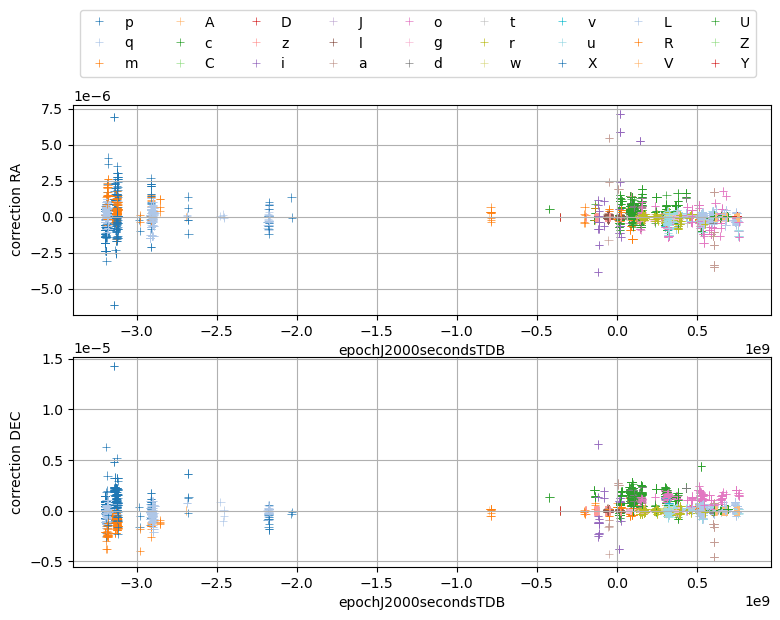

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6))

sns.scatterplot(
    x=time_original,
    y=RA_corr,
    marker="+",
    hue=catalogs,
    ax=ax1,
    palette=sns.color_palette("tab20"),
)
sns.scatterplot(
    x=time_original,
    y=DEC_corr,
    marker="+",
    hue=catalogs,
    ax=ax2,
    legend=False,
    palette=sns.color_palette("tab20"),
)
ax1.set_ylabel("correction RA")
ax2.set_ylabel("correction DEC")
ax1.legend(ncols=9, bbox_to_anchor=(0, 1.1), loc="lower left")
# ax2.legend()
ax1.grid()
ax2.grid()

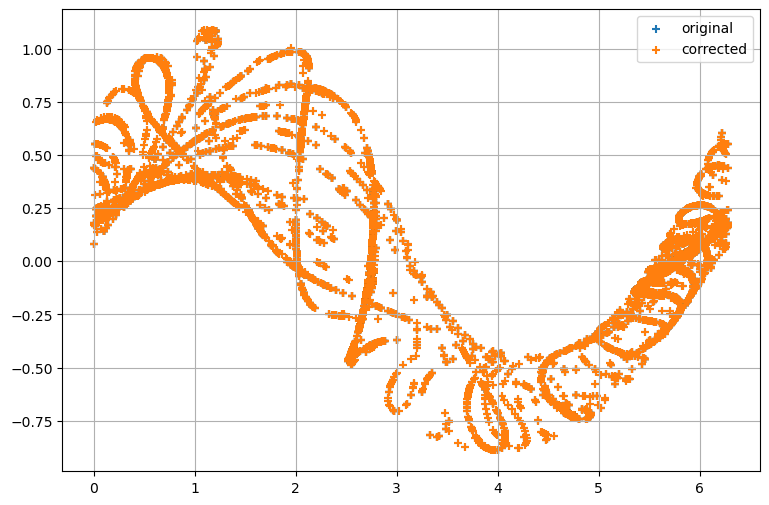

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.scatter(RA_original, DEC_original, marker="+", label="original")
ax.scatter(RA_corrected, DEC_corrected, marker="+", label="corrected")
ax.legend()
ax.grid()